In [1]:
# import libraries
import numpy as np
import pandas as pd
import torch
from pathlib import Path
import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings
import sys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache
from cnn_functions import *
from prepare_data import *

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# import unit cluster IDs
df      = pd.read_csv(r'Y:\buzsakilab\Buzsakilabspace\LabShare\NoamNitzan\Open_Access\Allen_2022\cluster_ids.csv')
# df.set_index('unit_id', inplace=True)
print(df.head())

cuda:0
      unit_id  cluster_id
0  1179685455           4
1  1179685422           2
2  1179685420           1
3  1179685635           1
4  1179685392           1


In [3]:
warnings.filterwarnings("ignore", message="Ignoring cached namespace")

output_dir = r"Y:\buzsakilab\Buzsakilabspace\LabShare\NoamNitzan\Open_Access\Allen_2022"
output_dir = Path(output_dir)
cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(cache_dir=output_dir)
session_id = 1044385384 # Arbitrary pick
session = cache.get_ecephys_session(ecephys_session_id=session_id)
behavior_id = session.behavior_session_id
behavior = cache.get_behavior_session(behavior_id)

In [4]:
units = session.get_units()
spike_times = session.spike_times
start = behavior.stimulus_presentations.start_time[behavior.stimulus_presentations.active].iloc[0]- 1
stop  = behavior.stimulus_presentations.end_time[behavior.stimulus_presentations.active].iloc[-1] + 1
stimSt = behavior.stimulus_presentations.start_time[behavior.stimulus_presentations.active]

# keep only units that are in the dataframe
units  = units[units.index.isin(df.unit_id)]
df_ses = df[df.unit_id.isin(units.index)].copy()

In [5]:
# balance the number of clusters by keeping only the minimum number of clusters
# get total numbers of clusters for each cluster
n_clusters = df_ses.groupby('cluster_id').size()
keep = []
for cluster in n_clusters.index:
    keep.append(df_ses.unit_id[df_ses.cluster_id == cluster].sample(n_clusters.min()).values)

df_ses = df_ses[df_ses.unit_id.isin(np.concatenate(keep))]
labels = df_ses.cluster_id.values - 1

In [7]:
bin_size = 0.01
sigma=3
win = [-.25, .5]

spkMat, timestamps = getSpkMat(spike_times, df_ses.unit_id, start, stop,bin_size, sigma)
Data, t = getSnippets(win, spkMat, timestamps, stimSt)

100%|██████████| 150/150 [00:04<00:00, 31.33it/s]


In [9]:
train_loader,test_loader = getDataLoaders(Data,labels)
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([135, 1, 75, 4500])
torch.Size([135])


In [ ]:
# test the model with one batch
net,lossfun,optimizer = createNet(printtoggle=True)

X,y = next(iter(train_loader))
yHat = net(X)[0]
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

Input: torch.Size([32, 1, 75, 4500])
Layer conv1/pool1: torch.Size([32, 10, 36, 2249])
Layer conv2/pool2: torch.Size([32, 20, 17, 1123])
Layer conv3/pool3: torch.Size([32, 30, 7, 560])
Vectorize: torch.Size([32, 117600])
Layer fc1: torch.Size([32, 50])
Layer out: torch.Size([32, 5])
 
Loss:
tensor(1.6234, grad_fn=<NllLossBackward0>)


100%|██████████| 30/30 [00:12<00:00,  2.43it/s]


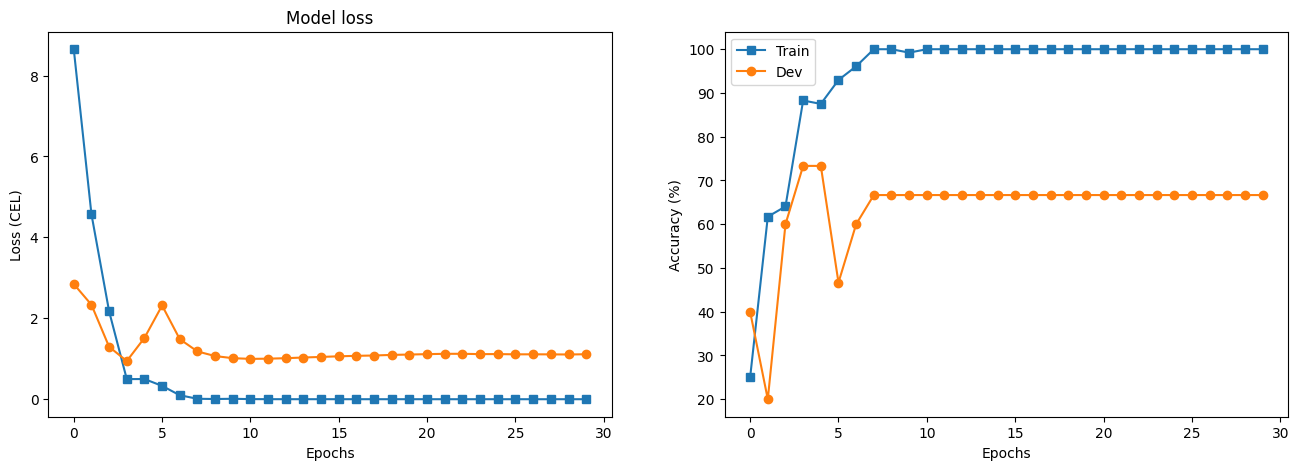

In [72]:
import importlib
import cnn_functions
importlib.reload(cnn_functions)
from cnn_functions import *

# train the model
net,lossfun,optimizer = createNet()
trainLoss,devLoss,trainAcc,devAcc,net = funtion2trainTheModel(net, lossfun, optimizer, train_loader, test_loader, numepochs=30, device = device)

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
# ax[0].plot(len(devLoss)-1,devLoss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Dev')
# ax[1].plot(len(devAcc)-1,devAcc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend()

plt.show()

In [ ]:
filename = Path(f'C:\\Users\SB13FLPC018\\vis_clusters\\cnn_model_state_{session_id}.pth')
torch.save(net.state_dict(), filename)

In [ ]:
# load session IDs
sessions  = np.load(r'Y:\buzsakilab\Buzsakilabspace\LabShare\NoamNitzan\Open_Access\Allen_2022\ses2analyze.npy')
testAcc = pd.DataFrame.from_dict({'session': sessions[0].astype(int), 'accuracy': [None] * len(sessions[0]), 'confMat': [[]] * len(sessions[0])})

In [ ]:
# load the model we trained and set to evaluation mode
filename = Path(f'C:\\Users\SB13FLPC018\\vis_clusters\\cnn_model_state_1044385384.pth')
net,lossfun,optimizer = createNet() 
net.load_state_dict(torch.load(filename)) 
net.eval()

# run on all sessions 
for i, session_id in enumerate(sessions[0]):
    
    msg = f'Working on session {session}'
    sys.stdout.write('\r' + msg)
    
    session = cache.get_ecephys_session(ecephys_session_id=session)
    behavior_id = session.behavior_session_id
    behavior = cache.get_behavior_session(behavior_id)
    
    units = session.get_units()
    units  = units[units.index.isin(df.unit_id)]
    df_ses = df[df.unit_id.isin(units.index)].copy()
    # balance
    n_clusters = df_ses.groupby('cluster_id').size()
    keep = []
    for cluster in n_clusters.index:
        keep.append(df_ses.unit_id[df_ses.cluster_id == cluster].sample(n_clusters.min()).values)
    df_ses = df_ses[df_ses.unit_id.isin(np.concatenate(keep))]
    labels = df_ses.cluster_id.values - 1
    
    spike_times = session.spike_times
    start  = behavior.stimulus_presentations.start_time[behavior.stimulus_presentations.active].iloc[0]- 1
    stop   = behavior.stimulus_presentations.end_time[behavior.stimulus_presentations.active].iloc[-1] + 1
    stimSt = behavior.stimulus_presentations.start_time[behavior.stimulus_presentations.active]

    spkMat, timestamps = getSpkMat(spike_times, df_ses.unit_id, start, stop,bin_size, sigma)
    Data, t = getSnippets(win, spkMat, timestamps, stimSt)
    
    # restrict to first 4500 stimuli
    Data = Data[:,:,:,:4500]
    labels = np.squeeze(labels[:4500]) - 1

    net,lossfun,optimizer = createNet() 

    if Data.shape[3] < 4500:
        testAcc['accuracy'].iloc[i] = np.nan
    else:
        # convert to tensor
        dataT   = torch.tensor( Data ).float()
        labelsT = torch.tensor( labels ).long()
        yHat = net(dataT)
        
        pred = np.argmax(yHat[0].detach().numpy(), axis=1)
        predAcc = torch.mean((torch.argmax(yHat[0],axis=1) == labelsT).float()).item()
        cm = confusion_matrix(pred, labelsT.detach().numpy())

        print(f' session {session_id} accuracy: {predAcc}')
        testAcc['accuracy'].iloc[i] = predAcc
        testAcc['confMat'].iloc[i]  = cm

In [ ]:
x = testAcc.confMat.values
x = np.stack(x)
np.save('confMat.npy', x)
testAcc[['session','accuracy']].to_csv('visCNN_testAcc.csv', index=False)